In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from utils.funs import scores

from transformers import AutoModelForCausalLM

/opt/homebrew/Caskroom/miniconda/base/envs/attention-geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def getscoresGEMMA(d,l,h,h_kv,dh,model):
    """
    Let Q and K be
    Q = X @ W_q ; K = X @ W_k

    it follows that the dot product between queries and keys is 
    Q @ K^T = X @ (W_q @ W_k^T) @ X^T = X @ M @ X^T 

    where M is a square matrix \in R^{d,d}, that can be decomposed into its
    symmetric and skew-symmetric part S and N, respectively,
    M = 1/2 * (M + M^T) + 1/2 * (M - M^T) = S + N

    important: nn.Linear.weight returns the learnable weights of the module as
    (out_features,in_features), then we can access the matrix W_q or 
    W_k as nn.Linear.weight^T

    Args:
        - d (int) : embeddding dimension.
        - l (int) : total number of layers
        - h (int) : number of heads.
        - dh (int) : embedding dimension per head.
        - model () : full model.

    Returns:
        - SList (numpy ndarray) : List of Symmetric (S) scores.
        - NList (numpy ndarray) : List of Skew-symmetric (N) scores.
    """

    SList = np.zeros((l,h))
    NList = np.zeros((l,h))
    
    # retrieve all BertLayer instances (the encoder in each layer)
    layers = model.model.layers

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.self_attn

        # access W_q and W_k: transpose the weight matrix and split into heads
        Wq = self_attention.q_proj._parameters["weight"].T.view(d,h,dh).detach().numpy()
        # GQA (grouped-query-attention) defines multiple key and value heads for the same query
        Wk = self_attention.k_proj._parameters["weight"].T.view(d,h_kv,dh).detach().numpy()

        ## Gemma 2b model has only one key and value matrix, shared across queries
        if h_kv == 1:

            for j in range(h):

                # calculate the association matrix M
                M = Wq[:,j,:] @ Wk[:,0,:].T
                # compute symmetry and skew-symmetry scores
                S, N = scores(M)
                SList[i,j], NList[i,j] = S, N

        ## Gemma 7b works with standard multi-head attention
        elif h_kv == h:

            for j in range(h):

                # calculate the association matrix M
                M = Wq[:,j,:] @ Wk[:,j,:].T
                # compute symmetry and skew-symmetry scores
                S, N = scores(M)
                SList[i,j], NList[i,j] = S, N

    return  SList, NList

In [3]:
"""
- KEY (str): model name
- VALUES (list): [layers (int), 
                  embedding dim (int), 
                  heads (int), 
                  head dim (int), 
                  S scores, 
                  N scores]
"""

if os.path.isfile('../../_data/fig_scores/GEMMA1-query-key.pkl'):
    with open('../../_data/fig_scores/GEMMA1-query-key.pkl', 'rb') as file:
        models = pickle.load(file)
else: models = {}

In [4]:
'Gemma model 2b (l = 18, d = 2048, h = 8, h_kv = 1 ; tot num parameters 2B)'
dh = 256
l = 18
d = 2048
h = 8
h_kv = 1
model = AutoModelForCausalLM.from_pretrained("google/gemma-1.1-2b-it")
S, N = getscoresGEMMA(d,l,h,h_kv,dh,model)
models['GEMMA2b'] = [l,d,h,h_kv,dh,S,N]

'Gemma model 7b (l = 18, d = 2048, h = 8, h_kv = 1 ; tot num parameters 7B)'
dh = 256
l = 28
d = 3072
h = 16
h_kv = 16
model = AutoModelForCausalLM.from_pretrained("google/gemma-1.1-7b-it")
S, N = getscoresGEMMA(d,l,h,h_kv,dh,model)
models['GEMMA7b'] = [l,d,h,h_kv,dh,S,N]

Loading checkpoint shards: 100%|██████████| 4/4 [00:57<00:00, 14.31s/it]


In [5]:
'save'
with open('../../_data/fig_scores/GEMMA1-query-key.pkl', 'wb') as file:
    pickle.dump(models, file)

(0.0, 1.0)

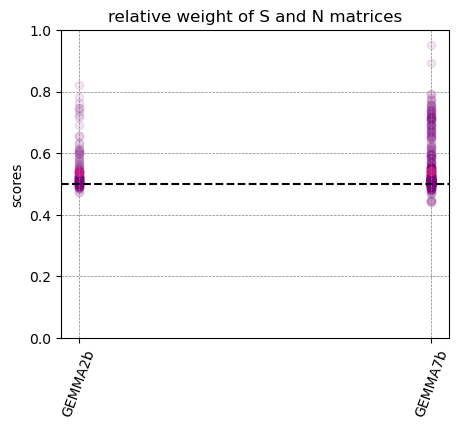

In [6]:
import matplotlib.pyplot as plt

with open('../../_data/fig_scores/GEMMA1-query-key.pkl', 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-2].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(5,4))

for i, model in enumerate(SList):
    
    plt.scatter(i*np.ones(SList[i].size),(SList[i].flatten()**2),color='purple',alpha=.1)
    plt.scatter(i,(SList[i].flatten()**2).mean(),color='mediumvioletred')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight of S and N matrices')
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=70)
plt.axhline(y=.5,color='k',linestyle='dashed')
plt.ylim(0,1)